In [1]:
import numpy as np
import numpy.linalg as npl
import scipy.linalg as spl
import sklearn.metrics as sklm
import math
import matplotlib.pyplot as plt
import pandas as pd #to help see arrays clearly when debugging 
plt.rcParams['figure.figsize'] = [9,9]
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
def levenberg_marquardt(f, Df, x1, lambda1, kmax = 100, tol = 1e-6):
    n = len(x1)
    x = x1
    lambd = lambda1
    objectives = [] 
    residuals = []
    for k in range(kmax):
        fk = f(x)
        Dfk = Df(x)
        objectives.append(npl.norm(fk)**2)
        residuals.append(npl.norm(2*np.matmul(Dfk.T,fk)))
        if npl.norm(2*np.matmul(Dfk.T,fk)) < tol:
            break
        xt = x - npl.lstsq(np.vstack([Dfk,np.sqrt(lambd)*np.eye(n)]),np.vstack([fk,np.zeros((n,1))]))[0].ravel()
        if npl.norm(f(xt)) < npl.norm(fk):
            lambd = .8*lambd
            x = xt
        else:
            lambd = 2.0*lambd
    return x, dict([("objectives", objectives),("residuals",residuals)])

# 19.1,2 Constrained Nonlinear Least Squares, Penalty Algorithm

"Let's implement the penalty algorithm (algorithm 19.1 in VMLS)."

In [3]:
def penalty_method(f, Df, g, Dg, x1, lambda1, kmax = 100, feas_tol = 1e-4, oc_tol = 1e-4):
    x = x1
    mu = 1.0
    feas_res = np.array([npl.norm(g(x))])
    oc_res = np.array([npl.norm(np.array(2*Df(x).T@f(x)).ravel() + 2 * mu * np.vstack(Dg(x))@g(x))])
    lm_iters = []  
    F = lambda x: np.vstack([f(x),np.sqrt(mu)*g(x)])
    DF = lambda x: np.vstack([Df(x), np.sqrt(mu)*Dg(x)])
    for k in range(kmax):
        x,hist = levenberg_marquardt(F,DF,x,lambda1,tol=oc_tol)
        feas_res = np.vstack([feas_res,npl.norm(g(x))])
        oc_res = np.vstack([oc_res,np.array(hist["residuals"])[-1]])
        lm_iters.append(len(hist["residuals"])) 
        if npl.norm(g(x)) < feas_tol:
            break
        mu = 2*mu    
    return x,dict([("lm_iterations", lm_iters), ("feas_res", feas_res),("oc_res", oc_res)])

On line $11$ we call the function `levenberg_marquardt` of the previous chapter to minimize $‖F(x)‖^2$ where

$$
F (x) =
\begin{bmatrix}
f(x)\\
\sqrt{µ}g(x)
\end{bmatrix}
.
$$

We evaluate two residuals. The “feasibility” residual $‖g(x(k))‖$ is the error in the constraint $g(x) = 0$. The “optimality condition” residual is defined as

$$
‖2Df(x^{(k)})^T f(x^{(k)}) + 2Dg(x^{(k)})^T z^{(k)}‖
$$

where $z(k) = 2µ(k−1)g(x(k))$ (and we take $µ(0) = µ(1)$). On line $13$, we obtain the optimality condition residual as the last residual in the Levenberg–Marquardt method. On line $20$ we return the final $x$, and a dictionary containing the two sequences of residuals and the number of iterations used in each call to the Levenberg–Marquardt algorithm.

**Example.** We apply the method to a problem with two variables

$$
f(x_1, x_2) =
\begin{bmatrix}
x_1 + exp(−x_2) \\
x^2_1 + 2x_2 + 1
\end{bmatrix}
, 
g(x_1, x_2) = x^2_1 + x^3_1 + x_2 + x^2_2.
$$


In [4]:
f = lambda x: np.vstack([x[0] + np.exp(-x[1]), x[0]**2 + 2*x[1]+1])
Df = lambda x: np.vstack([[1.0, -np.exp(-x[1])], [2*x[0], 2]])
g = lambda x: np.array([x[0] + x[0]**3 + x[1] + x[1]**2])
Dg = lambda x: np.hstack([1 + 3*x[0]**2, 1 + 2*x[1]])
x,hist = penalty_method(f,Df,g,Dg,[0.5,-0.5],1.0)
x

/home/linbo/anaconda3/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


array([-3.33495514e-05, -2.76824972e-05])

Text(0.5, 0, 'Cumulative Levenberg--Marquardt iterations')

Text(0, 0.5, 'Residual')

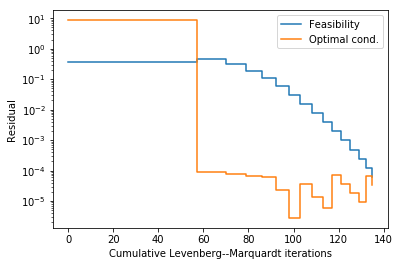

In [5]:
cum_lm_iters = np.cumsum(hist["lm_iterations"], axis=0)
itr = np.vstack([np.zeros(1),np.vstack(np.array([[i,i] for i in cum_lm_iters]).flatten())])
feas_res = np.vstack([np.vstack(np.array([[r,r] for r in hist["feas_res"][0:len(hist["feas_res"])-1]]).ravel()),hist["feas_res"][len(hist["feas_res"])-1]])
oc_res = np.vstack([np.vstack(np.array([[r,r] for r in hist["oc_res"][0:len(hist["oc_res"])-1]]).ravel()),hist["oc_res"][len(hist["oc_res"])-1]])
plt.plot(itr,feas_res)
plt.plot(itr,oc_res)
plt.yscale("log")
plt.xlabel("Cumulative Levenberg--Marquardt iterations")
plt.ylabel("Residual")
plt.legend(["Feasibility", "Optimal cond."])

# 19.3 Augmented Lagrangian Algorithm

In [6]:
def aug_lag_method(f,Df,g,Dg,x1,lambda1, kmax = 100, feas_tol = 1e-4, oc_tol = 1e-4):
    x = x1
    z = np.zeros(len(g(x)))
    mu = 1.0
    feas_res = np.array([npl.norm(g(x))])
    oc_res = np.array([npl.norm(np.array(2*Df(x).T@f(x)).ravel() + 2 * mu * np.vstack(Dg(x))@z)])
    lm_iters = []  
    F = lambda x: np.vstack([f(x),np.sqrt(mu)*g(x) + z/(2*mu)])
    DF = lambda x: np.vstack([Df(x), np.sqrt(mu)*Dg(x)])
    for k in range(kmax):
        x,hist = levenberg_marquardt(F,DF,x,lambda1,tol=oc_tol)
        z = z+2*mu*g(x)
        feas_res = np.vstack([feas_res,npl.norm(g(x))])
        oc_res = np.vstack([oc_res,np.array(hist["residuals"])[-1]])
        lm_iters.append(len(hist["residuals"])) 
        if npl.norm(g(x)) < feas_tol:
            break
        mu = mu if (npl.norm(g(x))<.25*feas_res[len(feas_res)-2]) else 2*mu 
    return x,z,dict([("lm_iterations", lm_iters), ("feas_res", feas_res),("oc_res", oc_res)])

In [7]:
x,z,hist = aug_lag_method(f,Df,g,Dg,[0.5,-0.5],1.0)
x
z

/home/linbo/anaconda3/envs/nlu/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


array([-3.09848096e-05, -2.56792929e-05])

array([-20.17787239])

Text(0.5, 0, 'Augmented Lagrangian Algorithm')

Text(0, 0.5, 'Residual')

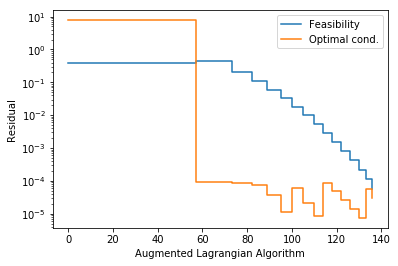

In [8]:
cum_lm_iters = np.cumsum(hist["lm_iterations"], axis=0)
itr = np.vstack([np.zeros(1),np.vstack(np.array([[i,i] for i in cum_lm_iters]).flatten())])
feas_res = np.vstack([np.vstack(np.array([[r,r] for r in hist["feas_res"][0:len(hist["feas_res"])-1]]).ravel()),hist["feas_res"][len(hist["feas_res"])-1]])
oc_res = np.vstack([np.vstack(np.array([[r,r] for r in hist["oc_res"][0:len(hist["oc_res"])-1]]).ravel()),hist["oc_res"][len(hist["oc_res"])-1]])
plt.plot(itr,feas_res)
plt.plot(itr,oc_res)
plt.yscale("log")
plt.xlabel("Augmented Lagrangian Algorithm")
plt.ylabel("Residual")
plt.legend(["Feasibility", "Optimal cond."])